In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'age', 'flag_train', 'gender', 'genre', 'itemId', 'maxSeqNum',
       'occupation', 'rating', 'seqNum',
       ...
       'f_tag_to', 'f_tag_trek', 'f_tag_wars', 'f_tag_weapon', 'f_tag_who',
       'f_tag_with', 'f_tag_world', 'f_tag_you', 'user_idx', 'item_idx'],
      dtype='object', length=389)

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_t')].tolist()

In [6]:
denseCols

['f_title_1939',
 'f_title_1940',
 'f_title_1941',
 'f_title_1942',
 'f_title_1944',
 'f_title_1946',
 'f_title_1950',
 'f_title_1951',
 'f_title_1953',
 'f_title_1954',
 'f_title_1955',
 'f_title_1956',
 'f_title_1957',
 'f_title_1958',
 'f_title_1959',
 'f_title_1960',
 'f_title_1961',
 'f_title_1962',
 'f_title_1963',
 'f_title_1964',
 'f_title_1965',
 'f_title_1966',
 'f_title_1967',
 'f_title_1968',
 'f_title_1969',
 'f_title_1970',
 'f_title_1971',
 'f_title_1972',
 'f_title_1973',
 'f_title_1974',
 'f_title_1975',
 'f_title_1976',
 'f_title_1977',
 'f_title_1978',
 'f_title_1979',
 'f_title_1980',
 'f_title_1981',
 'f_title_1982',
 'f_title_1983',
 'f_title_1984',
 'f_title_1985',
 'f_title_1986',
 'f_title_1987',
 'f_title_1988',
 'f_title_1989',
 'f_title_1990',
 'f_title_1991',
 'f_title_1992',
 'f_title_1993',
 'f_title_1994',
 'f_title_1995',
 'f_title_1996',
 'f_title_1997',
 'f_title_1998',
 'f_title_1999',
 'f_title_2000',
 'f_title_about',
 'f_title_adventures',
 'f_tit

In [7]:
genre_to_idx={j:i+1 for i,j in enumerate(dftrain['genre'].unique())}
idx_to_genre={i+1:j for i,j in enumerate(dftrain['genre'].unique())}
dftrain['genre_idx']=[genre_to_idx.get(i) for i in dftrain['genre']]
dfvalid['genre_idx']=[genre_to_idx.get(i) for i in dfvalid['genre']]

In [8]:
occupation_to_idx={j:i+1 for i,j in enumerate(dftrain['occupation'].unique())}
idx_to_occupation={i+1:j for i,j in enumerate(dftrain['occupation'].unique())}
dftrain['occupation_idx']=[occupation_to_idx.get(i) for i in dftrain['occupation']]
dfvalid['occupation_idx']=[occupation_to_idx.get(i) for i in dfvalid['occupation']]

In [9]:
age_to_idx={j:i+1 for i,j in enumerate(dftrain['age'].unique())}
idx_to_age={i+1:j for i,j in enumerate(dftrain['age'].unique())}
dftrain['age_idx']=[age_to_idx.get(i) for i in dftrain['age']]
dfvalid['age_idx']=[age_to_idx.get(i) for i in dfvalid['age']]

In [10]:
gender_to_idx={j:i+1 for i,j in enumerate(dftrain['gender'].unique())}
idx_to_gender={i+1:j for i,j in enumerate(dftrain['gender'].unique())}
dftrain['gender_idx']=[gender_to_idx.get(i) for i in dftrain['gender']]
dfvalid['gender_idx']=[gender_to_idx.get(i) for i in dfvalid['gender']]

In [11]:
catCols=['genre_idx','occupation_idx','age_idx','gender_idx']

### Dataset and DataLoader

In [12]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols,catCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        self.catCols=catCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [13]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols+catCols],dftrain['rating'],denseCols,catCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols+catCols],dfvalid['rating'],denseCols,catCols)

In [14]:
dftrain.shape

(894131, 393)

In [15]:
bs=64

In [16]:
dltrain=DataLoader(dstrain,bs,True)

In [17]:
dlvalid=DataLoader(dsvalid,bs,False)

In [18]:
dftrain['genre'].nunique()

301

In [19]:
[(col, dftrain[col].nunique()) for col in catCols]

[('genre_idx', 301), ('occupation_idx', 21), ('age_idx', 7), ('gender_idx', 2)]

In [20]:
{col: min(50,dftrain[col].nunique()//100) for col in catCols}

{'genre_idx': 3, 'occupation_idx': 0, 'age_idx': 0, 'gender_idx': 0}

In [21]:
emb_szs=[(dftrain[col].nunique(),min(50,dftrain[col].nunique()//2)) for col in catCols]

In [22]:
emb_szs

[(301, 50), (21, 10), (7, 3), (2, 1)]

## Model Architecture

In [82]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.1
    # embedding, dense, cat, final
hidden=[20,10,10,5]
dropouts=[0.2,0.3,0.2,0.1]

In [73]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [100]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=None

In [132]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 catCols, emb_szs,dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.catCols,self.emb_szs=catCols,emb_szs
        self.len_cat_cols=len(self.catCols)
        self.n_cat_emb=sum([x[1] for x in emb_szs])
        
        
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.embs_cat=nn.ModuleList([nn.Embedding(x+1,y) for x,y in self.emb_szs])
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
       
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin_cat= nn.Sequential (nn.Linear(self.n_cat_emb,self.hidden[2]),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[2]))
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1+self.hidden[2],self.hidden[3]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[3]))
        self.lin4=nn.Linear(self.hidden[3],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:(2+self.len_dense_cols)]
        out2=self.lin2(denses)
                  
        cats=Xb[:,(2+self.len_dense_cols):].long()
        embed_cat=[self.emb_dropout(self.embs_cat[i](cats[:,i]) ) for i in range(len(self.emb_szs))]
        embedded_cat = torch.cat([x for x in embed_cat],1)
        out_cat=self.lin_cat(embedded_cat)
        
        out3=torch.cat([out1,out2,biased,out_cat],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        #out=self.sigmoid(out5)
        
        preds=out5 #*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [133]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [103]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(302, 50)
    (1): Embedding(22, 10)
    (2): Embedding(8, 3)
    (3): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin3): Sequential(
    (0): Linear(in_features=41, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (lin4): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [104]:
for Xb, Yb in dltrain:
    break

In [105]:
Xb.shape, Yb.shape

(torch.Size([64, 356]), torch.Size([64, 1]))

In [106]:
Xb.dtype

torch.float32

In [107]:
cfobj.forward(Xb,Yb)

(tensor([[2.9248],
         [2.8515],
         [2.9054],
         [3.2473],
         [3.0239],
         [2.9110],
         [2.7908],
         [2.9092],
         [2.6918],
         [2.9174],
         [2.8382],
         [2.6921],
         [3.1494],
         [2.3713],
         [2.7213],
         [2.4919],
         [2.8246],
         [2.5860],
         [2.7288],
         [2.7289],
         [2.7915],
         [2.7199],
         [2.4797],
         [3.0035],
         [3.0725],
         [2.7776],
         [2.4873],
         [3.2931],
         [3.0144],
         [2.7093],
         [2.9137],
         [2.9051],
         [2.6545],
         [2.7773],
         [2.7605],
         [3.0620],
         [3.2054],
         [2.7058],
         [2.7503],
         [3.0508],
         [2.9647],
         [2.5005],
         [2.7431],
         [2.9100],
         [2.6146],
         [2.9404],
         [2.8819],
         [3.2737],
         [2.8253],
         [2.7912],
         [2.8583],
         [2.8324],
         [3.

## Learner

In [108]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [134]:
device='cuda:0'

In [135]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [136]:
cfobj=cfobj.to(device)

In [137]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(302, 50)
    (1): Embedding(22, 10)
    (2): Embedding(8, 3)
    (3): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.1)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=350, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin_cat): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin3): Sequential(
    (0): Linear(in_features=41, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (lin4): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [138]:
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [139]:
len(dltrain)

13971

In [140]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:12000 1.4753422251269221  


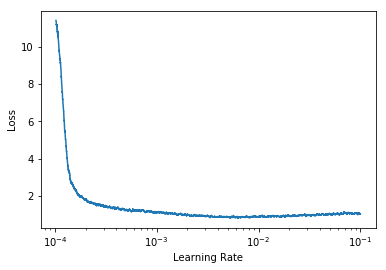

In [141]:
learner.plot_lrs(50)

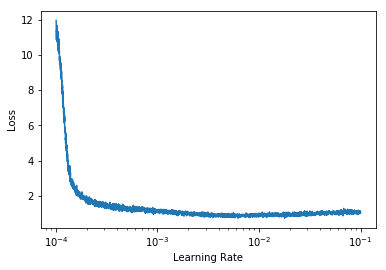

In [142]:
learner.plot_lrs(10)

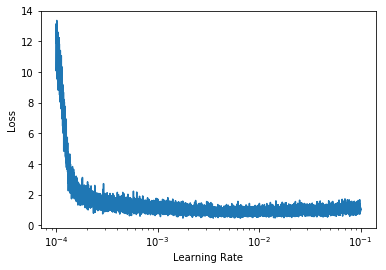

In [143]:
learner.plot_lrs(1)

In [144]:
del cfobj
torch.cuda.empty_cache()

In [145]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [146]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [147]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [148]:
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4,wd_mult=1.2)

In [ ]:
learner.run_epochs(dltrain,dlvalid,7)

Batch:12000 1.0787293953125676  
Epoch:0 Learning rate 0.001 Weight Decay 1e-05 Train Loss:1.0429543212752634                 Valid Loss:0.8199560397964047 Train RMSE:0.995450221236052 Valid RMSE:0.8916715726437009 Train MSE:1.0429543212752634 Valid MSE:0.8199560397964047                 Train MAE:0.7966460777492891 Valid MAE:0.7196639305468204
Batch:12000 0.8146405734270811  
Epoch:1 Learning rate 0.00031622776601683794 Weight Decay 1.2e-05 Train Loss:0.8153112746903673                 Valid Loss:0.8135599215999155 Train RMSE:0.8989113078488219 Valid RMSE:0.8878763841764 Train MSE:0.8153112746903673 Valid MSE:0.8135599215999155                 Train MAE:0.7148646713391071 Valid MAE:0.7134866880745019


In [51]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [52]:
if 1==1:
    optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.001 Weight Decay 1e-05 Train Loss:0.7805559978703869                 Valid Loss:0.7893036750961989 Train RMSE:0.8814458818943326 Valid RMSE:0.8800204313590931 Train MSE:0.7805559978703869 Valid MSE:0.7893036750961989                 Train MAE:0.6999618800038634 Valid MAE:0.7022615412319814
Epoch:1 Learning rate 0.00031622776601683794 Weight Decay 1.15e-05 Train Loss:0.7436541427889902                 Valid Loss:0.7732859177669944 Train RMSE:0.8603399845161078 Valid RMSE:0.8710331924950633 Train MSE:0.7436541427889902 Valid MSE:0.7732859177669944                 Train MAE:0.6820098056924264 Valid MAE:0.6936925420643193
Epoch:2 Learning rate 0.0001 Weight Decay 1.3225e-05 Train Loss:0.7258223787039697                 Valid Loss:0.7708407285273866 Train RMSE:0.8499522372097409 Valid RMSE:0.8695936960392975 Train MSE:0.7258223787039697 Valid MSE:0.7708407285273866                 Train MAE:0.6728294702935212 Valid MAE:0.6912090462352743
Epoch:3 Learning rate 0.001 W

In [53]:
learner.generate_scores=True

In [54]:
learner.run_epoch(dlvalid,False)

(0.7668299323039981, 0.6892825165545552, 0.8673695456775246)

In [55]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [56]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8757294306251237

In [57]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [58]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.767020,0.875797,0.689360,0.416411,No-cold-start
1,dnnrec,0.655376,0.809553,0.643343,0.059375,User-Cold-Start
2,dnnrec,0.866406,0.930809,0.751230,0.062893,Item-Cold_start
0,dnnrec,0.767020,0.875797,0.689360,0.416411,0
1,dnnrec,0.690332,0.830862,0.661214,0.112225,1
0,dnnrec,0.766902,0.875729,0.689316,0.416138,0


In [59]:
results_concat.shape

(66, 6)

In [60]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [61]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec_tl.pkl','wb'))